In [23]:

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_scipy_sparse_matrix
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh  # For large sparse matrices
from numpy.linalg import eigh  # For dense matrices
from torch import nn


# Task 1: Implement Laplacian Positional Encodings (LapPE)
 - Compute Laplacian eigenvectors using the graph Laplacian matrix `L = D - A`.
 - Use `eigh` for efficient eigendecomposition (optimized for Hermitian matrices).
 - Handle sign ambiguity in eigenvectors (random flipping or SignNet).
 - Ensure embeddings are robust to sign flips and can capture graph structure.

In [24]:

def compute_lap_pe(data, pe_dim=10, use_signnet=False):
    """
    Compute Laplacian Positional Encodings (LapPE) for a given graph data.

    Args:
        data (torch_geometric.data.Data): Graph data object.
        pe_dim (int): Number of eigenvectors to compute.
        use_signnet (bool): Whether to handle sign ambiguity using SignNet.

    Returns:
        data (torch_geometric.data.Data): Graph data object with 'lap_pe' attribute added.
    """
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    # Convert to scipy sparse matrix
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).astype(float)

    # Compute the Laplacian matrix
    laplacian = csgraph.laplacian(adj, normed=False)

    # For large sparse matrices, use eigsh
    try:
        # Compute the smallest k+1 eigenvalues and eigenvectors
        eigvals, eigvecs = eigsh(laplacian, k=pe_dim+1, which='SM')
        eigvecs = eigvecs[:, eigvals.argsort()]  # Sort eigenvectors
    except RuntimeError:
        # Fall back to dense computation for small graphs
        laplacian_dense = laplacian.toarray()
        eigvals, eigvecs = eigh(laplacian_dense)
        eigvecs = eigvecs[:, eigvals.argsort()]

    # Exclude the first eigenvector (corresponding to the smallest eigenvalue)
    pe = eigvecs[:, 1:pe_dim+1]

    # Handle sign ambiguity
    if use_signnet:
        # SignNet implementation (placeholder)
        # You would implement SignNet as a neural network layer in your model
        # For now, we'll assume the sign ambiguity is handled during model training
        pass
    else:
        # Randomly flip signs during training (data augmentation)
        # This helps the model to be robust to sign flips
        sign_flip = np.random.choice([-1, 1], size=(pe.shape[1],))
        pe = pe * sign_flip

    # Convert to torch tensor
    pe_tensor = torch.from_numpy(pe).float()

    # Add to data
    data.lap_pe = pe_tensor

    return data



Example

In [25]:

# Create a simple graph
# For this example, we'll create a graph with 5 nodes and some edges
edge_index = torch.tensor([
    [0, 1, 2, 3, 0, 2],
    [1, 2, 3, 4, 4, 0]
], dtype=torch.long)

# Create a Data object
data = Data(edge_index=edge_index)

# Set the number of nodes (important if some nodes have no edges)
data.num_nodes = 5

# Optionally, add node features (here we just use ones)
data.x = torch.ones((data.num_nodes, 1))

# Compute the Laplacian Positional Encodings
data = compute_lap_pe(data, pe_dim=3, use_signnet=False)

# Print the computed positional encodings
print("Laplacian Positional Encodings (lap_pe):")
print(data.lap_pe)



Laplacian Positional Encodings (lap_pe):
tensor([[-0.1411, -0.6585, -0.3852],
        [-0.7979,  0.4839,  0.0434],
        [ 0.3492,  0.0792,  0.6216],
        [ 0.4431,  0.5017, -0.3190],
        [ 0.1588,  0.2724, -0.6014]])


# Task 2: Combine LapPE with SignNet
   - Implement SignNet to make the model sign-invariant.
   - Use SignNet to process the eigenvectors of the Laplacian to produce consistent embeddings.


In [26]:
class SignNet(nn.Module):
    """
    SignNet: A neural network that is invariant to the sign flips of input eigenvectors.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2):
        super(SignNet, self).__init__()
        self.num_layers = num_layers
        self.mlp = nn.ModuleList()
        for _ in range(num_layers):
            self.mlp.append(nn.Linear(in_dim if _ == 0 else hidden_dim, hidden_dim))
        self.out_layer = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        """
        Forward pass for SignNet.

        Args:
            x (torch.Tensor): Input eigenvectors of shape (num_nodes, pe_dim)

        Returns:
            torch.Tensor: Sign-invariant embeddings of shape (num_nodes, out_dim)
        """
        # Compute both x and -x
        x_pos = x
        x_neg = -x

        # Pass through MLP separately
        for layer in self.mlp:
            x_pos = F.relu(layer(x_pos))
            x_neg = F.relu(layer(x_neg))

        # Sum the outputs to get sign-invariant representation
        x = x_pos + x_neg

        # Final output layer
        x = self.out_layer(x)

        return x

def compute_lap_pe_with_signnet(data, pe_dim=10, hidden_dim=64, out_dim=32, num_layers=2):
    """
    Compute Laplacian Positional Encodings and process them with SignNet.

    Args:
        data (torch_geometric.data.Data): Graph data object.
        pe_dim (int): Number of eigenvectors to compute.
        hidden_dim (int): Hidden dimension for SignNet.
        out_dim (int): Output dimension for SignNet embeddings.
        num_layers (int): Number of layers in SignNet.

    Returns:
        data (torch_geometric.data.Data): Graph data object with 'sign_inv_lap_pe' attribute added.
    """
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    # Convert to scipy sparse matrix
    from torch_geometric.utils import to_scipy_sparse_matrix
    import numpy as np
    from scipy.sparse import csgraph
    from scipy.sparse.linalg import eigsh
    from numpy.linalg import eigh

    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).astype(float)

    # Compute the Laplacian matrix
    laplacian = csgraph.laplacian(adj, normed=False)

    # For large sparse matrices, use eigsh
    try:
        eigvals, eigvecs = eigsh(laplacian, k=pe_dim+1, which='SM')
        eigvecs = eigvecs[:, eigvals.argsort()]  # Sort eigenvectors
    except RuntimeError:
        laplacian_dense = laplacian.toarray()
        eigvals, eigvecs = eigh(laplacian_dense)
        eigvecs = eigvecs[:, eigvals.argsort()]

    # Exclude the first eigenvector (corresponding to the smallest eigenvalue)
    pe = eigvecs[:, 1:pe_dim+1]

    # Convert to torch tensor
    pe_tensor = torch.from_numpy(pe).float()  # Shape: (num_nodes, pe_dim)

    # Initialize SignNet
    signnet = SignNet(in_dim=pe_dim, hidden_dim=hidden_dim, out_dim=out_dim, num_layers=num_layers)

    # Process the positional encodings with SignNet
    sign_inv_pe = signnet(pe_tensor)  # Shape: (num_nodes, out_dim)

    # Add to data
    data.sign_inv_lap_pe = sign_inv_pe

    return data


## Example


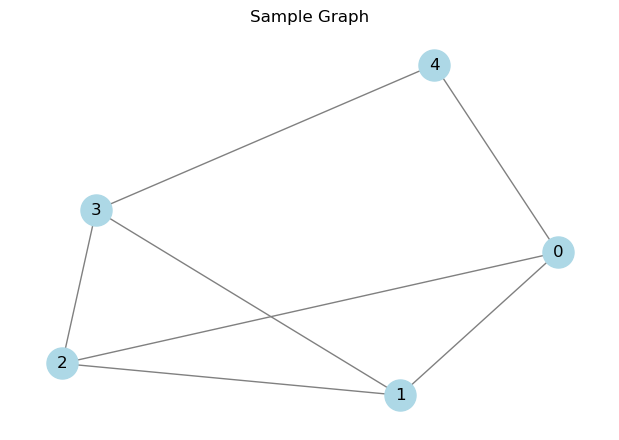

In [27]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a simple undirected graph
G = nx.Graph()
# Add nodes and edges
G.add_edges_from([
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 4),
    (4, 0),
    (1, 3),
    (0, 2)
])

# Visualize the graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Sample Graph")
plt.show()


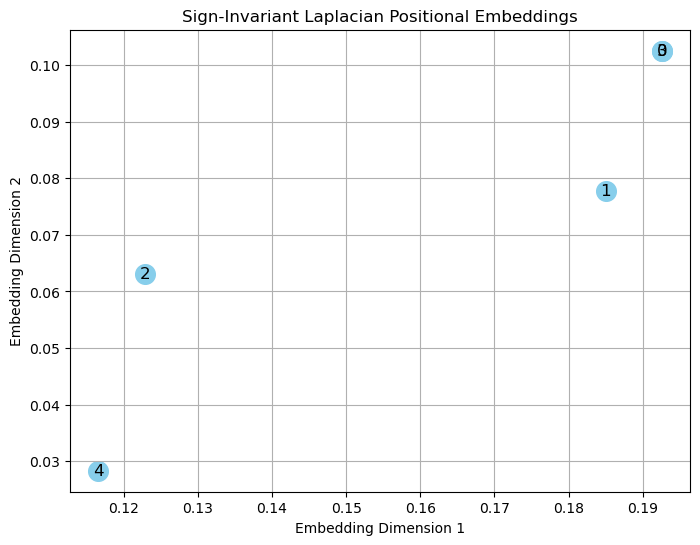

In [29]:
# Convert NetworkX graph to PyTorch Geometric data
from torch_geometric.utils import from_networkx

data = from_networkx(G)
# Ensure the number of nodes is set
data.num_nodes = G.number_of_nodes()

# Optionally, add dummy node features (e.g., ones)
data.x = torch.ones((data.num_nodes, 1))

# Set parameters
pe_dim = 3        # Number of eigenvectors to compute (excluding the first trivial one)
hidden_dim = 32    # Hidden dimension for SignNet
out_dim = 2        # Output dimension for embeddings (for 2D visualization)
num_layers = 2     # Number of layers in SignNet

# Compute sign-invariant Laplacian Positional Encodings
data = compute_lap_pe_with_signnet(data, pe_dim=pe_dim, hidden_dim=hidden_dim, out_dim=out_dim, num_layers=num_layers)

# Extract the embeddings
embeddings = data.sign_inv_lap_pe.detach().numpy()  # Convert to NumPy array for plotting

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='skyblue', s=200)

# Annotate each point with the node index
for i, (x, y) in enumerate(embeddings):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

plt.title("Sign-Invariant Laplacian Positional Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()

